http://geologyandpython.com/get-landsat-8.html

https://landsat.gsfc.nasa.gov/landsat-8/



In [1]:
import rasterio
import rasterio.plot
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
import fiona

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import shapely
import folium

# Import requests and beautiful soup
import os
import shutil
import requests
from bs4 import BeautifulSoup


import cartopy.crs as ccrs
from glob import glob

In [2]:
%matplotlib nbagg

In [3]:
counties = fiona.open('./support/counties/cb_2017_us_county_500k.shp')

for county in counties:
    if county['properties']['NAME'] == 'Madison' and county['properties']['STATEFP'] == '01':
        break
        
madison = county
madison_boundary = shapely.geometry.shape(madison['geometry'])

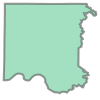

In [4]:
madison_boundary

In [5]:
# https://landsat.usgs.gov/pathrow-shapefiles

wrs = gpd.GeoDataFrame.from_file('./support/landsat8/WRS2_descending.shp')
wrs.head()

,AREA,PERIMETER,PR_,PR_ID,RINGS_OK,RINGS_NOK,PATH,ROW,MODE,SEQUENCE,WRSPR,PR,ACQDayL7,ACQDayL8,geometry
0,15.74326,26.98611,1.0,1.0,1,0,13,1,D,2233,013001,013001,1,9,"POLYGON ((-10.80341356392465 80.9888, -8.97406..."
1,14.55366,25.84254,2.0,2.0,1,0,13,2,D,2234,013002,013002,1,9,POLYGON ((-29.24250366707619 80.18681161921363...
2,13.37247,24.20303,3.0,3.0,1,0,13,3,D,2235,013003,013003,1,9,POLYGON ((-24.04205646041896 79.12261247629547...
3,12.26691,22.40265,4.0,4.0,1,0,13,4,D,2236,013004,013004,1,9,POLYGON ((-36.66813132081753 77.46094098591608...
4,11.26511,20.64284,5.0,5.0,1,0,13,5,D,2237,013005,013005,1,9,POLYGON ((-44.11209517917457 76.93655561966702...


In [6]:
wrs_intersection = wrs[wrs.intersects(madison_boundary)]
paths, rows = wrs_intersection['PATH'].values, wrs_intersection['ROW'].values

In [7]:
xy = np.asarray(madison_boundary.centroid.xy).squeeze()
center = list(xy[::-1])
zoom = 8
m = folium.Map(location=center, zoom_start=zoom, control_scale=True)

m.add_child(folium.GeoJson(madison_boundary.__geo_interface__, style_function=lambda x: {'color': 'red', 'alpha': 0}))

for (i, row) in wrs_intersection.iterrows():
    name = 'path: %03d, row: %03d' % (row.PATH, row.ROW)
    g = folium.GeoJson(row.geometry.__geo_interface__, name=name)
    g.add_child(folium.Popup(name))
    g.add_to(m)

m

https://landsatonaws.com/

Landsat on AWS makes Landsat data available for anyone to use via Amazon S3. All Landsat 8 scenes from 2015 are available along with a selection of cloud-free scenes from 2013 and 2014. All new Landsat 8 scenes are made available each day, often within hours of production.

The data are organized using a directory structure based on each scene’s path and row. For instance, the files for Landsat scene LC08_L1TP_139045_20170304_20170316_01_T1 are available in the following location: s3://landsat-pds/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/

The “c1” refers to Collection 1, the “L8” refers to Landsat 8, “139” refers to the scene’s path, “045” refers to the scene’s row, and the final directory matches the product’s identifier, which uses the following naming convention: LXSS_LLLL_PPPRRR_YYYYMMDD_yyymmdd_CC_TX, in which:

* L = Landsat
* X = Sensor
* SS = Satellite
* PPP = WRS path
* RRR = WRS row
* YYYYMMDD = Acquisition date
* yyyymmdd = Processing date
* CC = Collection number
* TX = Collection category


In [8]:
s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', compression='gzip')

In [9]:
s3_scenes.head(3)

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
0,LC08_L1TP_149039_20170411_20170415_01_T1,LC81490392017101LGN00,2017-04-11 05:36:29.349932,0.00,L1TP,149,39,29.22165,72.41205,31.34742,74.84666,https://s3-us-west-2.amazonaws.com/landsat-pds...
1,LC08_L1TP_012001_20170411_20170415_01_T1,LC80120012017101LGN00,2017-04-11 15:14:40.001201,0.15,L1TP,12,1,79.51504,-22.06995,81.90314,-7.44339,https://s3-us-west-2.amazonaws.com/landsat-pds...
2,LC08_L1TP_012002_20170411_20170415_01_T1,LC80120022017101LGN00,2017-04-11 15:15:03.871058,0.38,L1TP,12,2,78.74882,-29.24387,81.14549,-15.04330,https://s3-us-west-2.amazonaws.com/landsat-pds...


In [11]:
# Empty list to add the images
bulk_list = []

# Iterate through paths and rows
for path, row in zip(paths, rows):

    print('Path:',path, 'Row:', row)

    # Filter the Landsat Amazon S3 table for images matching path, row, cloudcover and processing state.
    scenes = s3_scenes[(s3_scenes.path == path) & (s3_scenes.row == row) & 
                       (s3_scenes.cloudCover <= 5) & 
                       (~s3_scenes.productId.str.contains('_T2')) &
                       (~s3_scenes.productId.str.contains('_RT'))]
    print(' Found {} images\n'.format(len(scenes)))

    # If any scenes exists, select the one that have the minimum cloudCover.
    if len(scenes):
        scene = scenes.sort_values('cloudCover').iloc[0]

    # Add the selected scene to the bulk download list.
    bulk_list.append(scene)

Path: 20 Row: 36
 Found 5 images

Path: 21 Row: 36
 Found 11 images



In [12]:
bulk_frame = pd.concat(bulk_list, 1).T
bulk_frame

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
216834,LC08_L1TP_020036_20170910_20170927_01_T1,LC80200362017253LGN00,2017-09-10 16:18:39.384519,2.2,L1TP,20,36,33.5375,-87.0983,35.6623,-84.6275,https://s3-us-west-2.amazonaws.com/landsat-pds...
391038,LC08_L1TP_021036_20180208_20180221_01_T1,LC80210362018039LGN00,2018-02-08 16:24:34.252234,0.02,L1TP,21,36,33.5359,-88.6825,35.656,-86.1491,https://s3-us-west-2.amazonaws.com/landsat-pds...


In [ ]:

LANDSAT_PATH = './support/landsat'

# For each row
for i, row in bulk_frame.iterrows():

    # Print some the product ID
    print('\n', 'EntityId:', row.productId, '\n')
    print(' Checking content: ', '\n')

    # Request the html text of the download_url from the amazon server. 
    # download_url example: https://landsat-pds.s3.amazonaws.com/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/index.html
    response = requests.get(row.download_url)

    # If the response status code is fine (200)
    if response.status_code == 200:

        # Import the html to beautiful soup
        html = BeautifulSoup(response.content, 'html.parser')

        # Create the dir where we will put this image files.
        entity_dir = os.path.join(LANDSAT_PATH, row.productId)
        os.makedirs(entity_dir, exist_ok=True)

        # Second loop: for each band of this image that we find using the html <li> tag
        for li in html.find_all('li'):

            # Get the href tag
            file = li.find_next('a').get('href')

            print('  Downloading: {}'.format(file))

            # Download the files
            # code from: https://stackoverflow.com/a/18043472/5361345

            response = requests.get(row.download_url.replace('index.html', file), stream=True)

            with open(os.path.join(entity_dir, file), 'wb') as output:
                shutil.copyfileobj(response.raw, output)
            del response

In [13]:
xmin, xmax, ymin, ymax = [], [], [], []

for image_path in glob(os.path.join('./support/landsat/', '*/*B1.TIF')):
    with rasterio.open(image_path) as src_raster:
        xmin.append(src_raster.bounds.left)
        xmax.append(src_raster.bounds.right)        
        ymin.append(src_raster.bounds.bottom)        
        ymax.append(src_raster.bounds.top)        

https://landsat.usgs.gov/what-are-band-designations-landsat-satellites

http://alabamamaps.ua.edu/contemporarymaps/alabama/basemaps/utm.pdf

<IPython.core.display.Javascript object>


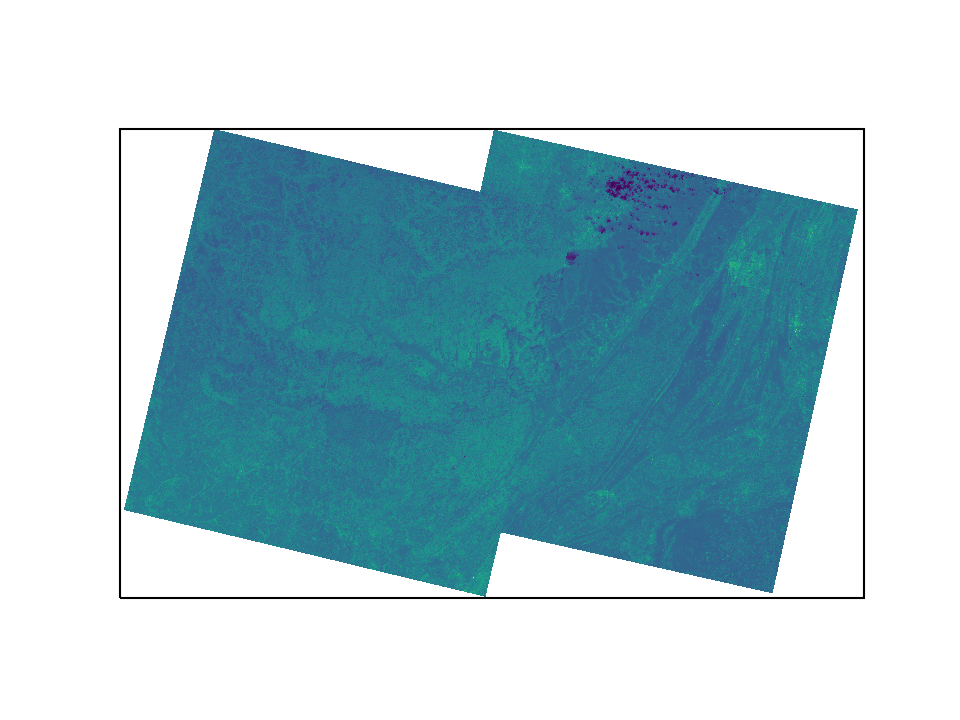

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/rasterio/warp.py:250: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  if src_transform and guard_transform(src_transform).is_identity:
/usr/lib/python3/dist-packages/rasterio/warp.py:256: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  src_transform = guard_transform(src_transform).to_gdal()


In [14]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.UTM(16)})

ax.set_extent([min(xmin), max(xmax), min(ymin), max(ymax)], ccrs.UTM(16))

for image_path in glob(os.path.join('./support/landsat/', '*/*B10.TIF')):

    with rasterio.open(image_path) as src_raster:

        extent = [src_raster.bounds[i] for i in [0, 2, 1, 3]]  

        dst_transform = from_origin(src_raster.bounds.left, src_raster.bounds.top, 250, 250)

        width = np.ceil((src_raster.bounds.right - src_raster.bounds.left) / 250.).astype('uint')
        height = np.ceil((src_raster.bounds.top - src_raster.bounds.bottom) / 250.).astype('uint')

        dst = np.zeros((height, width))

        reproject(src_raster.read(1), dst, 
                  src_transform=src_raster.transform, 
                  dst_transform=dst_transform,
                  resampling=Resampling.nearest)

        ax.matshow(np.ma.masked_equal(dst, 0), extent=extent, transform=ccrs.UTM(16))

The normalized difference vegetation index (NDVI) is a simple graphical indicator that can be used to analyze remote sensing measurements, typically, but not necessarily, from a space platform, and assess whether the target being observed contains live green vegetation or not.

https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index

In [15]:
band4 = rasterio.open('./support/landsat/LC08_L1TP_020036_20170910_20170927_01_T1/LC08_L1TP_020036_20170910_20170927_01_T1_B4.TIF')
band5 = rasterio.open('./support/landsat/LC08_L1TP_020036_20170910_20170927_01_T1/LC08_L1TP_020036_20170910_20170927_01_T1_B5.TIF')

nir = band5.read(1)
red = band4.read(1)

nir = nir.astype(np.double)
red = red.astype(np.double)

In [16]:
mask = np.logical_and(nir > 1, red > 1)

In [17]:
ndvi = np.where(mask, (nir - red) / (nir + red), 0)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


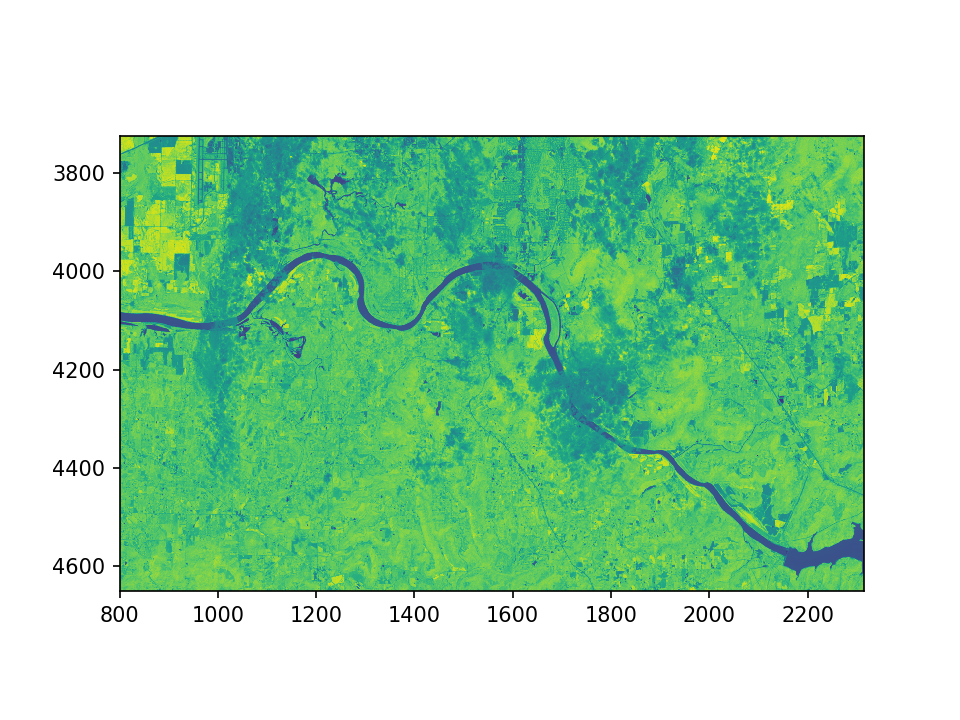

In [18]:
plt.figure()
plt.imshow(ndvi)